In [1]:
%load_ext autoreload
%reload_ext autoreload
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


# Swinging Sticks Runner
> Train and analyze performance on swinging sticks dataset

In [2]:

import jax
import jax.numpy as jnp
import numpy as np
import optax

from copy import deepcopy
import logging
from tqdm.notebook import trange
from functools import partial
import os

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

from jaxDiversity.dataloading import SwingingSticksDataset,NumpyLoader
from jaxDiversity.utilclasses import InnerConfig, OuterConfig
from jaxDiversity.mlp import mlp_afunc, MultiActMLP
from jaxDiversity.baseline import compute_loss as compute_loss_baseline
from jaxDiversity.hnn import compute_loss as compute_loss_hnn
from jaxDiversity.loops import inner_opt, outer_opt


In [4]:
sns.set_theme(context='notebook', style='dark', palette='pastel', font_scale=1, color_codes=True, rc={'text.usetex' : True})
plt.style.use('dark_background')


In [5]:
# Configure the logger
logging.basicConfig(level=logging.INFO)

In [6]:
# run on cpu
jax.config.update('jax_platform_name', 'cpu')
logging.info(f'jax backend: {jax.lib.xla_bridge.get_backend().platform}')

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:jax backend: cpu


### Test dataset access

In [7]:

TEST_TRAIN_SPLIT = 0.8
data_path = "../data/SwingingSticks/"
train_dataset = SwingingSticksDataset(data_path, TEST_TRAIN_SPLIT, train=True)
test_dataset = SwingingSticksDataset(data_path, TEST_TRAIN_SPLIT, train=False)

train_dataloader = NumpyLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = NumpyLoader(test_dataset, batch_size=8, shuffle=True)

x,y = next(iter(train_dataloader))

assert x.shape == (8, 4)
assert y.shape == (8, 4)


### test inner loop

In [8]:
# test inner_opt
dev_inner_config = InnerConfig(test_train_split=0.8,
                            input_dim=4,
                            output_dim=4,
                            hidden_layer_sizes=[18],
                            batch_size=64,
                            epochs=2,
                            lr=1e-3,
                            mu=0.9,
                            n_fns=2,
                            l2_reg=1e-1,
                            seed=42)
key = jax.random.PRNGKey(dev_inner_config.seed)
model_key, init_key = jax.random.split(key)
afuncs = [lambda x: x**2, lambda x: x]
data_path = "../data/SwingingSticks/"
train_dataset = SwingingSticksDataset(data_path, dev_inner_config.test_train_split, train=True)
test_dataset = SwingingSticksDataset(data_path, dev_inner_config.test_train_split, train=False)
train_dataloader = NumpyLoader(train_dataset, batch_size=dev_inner_config.batch_size, shuffle=True)
test_dataloader = NumpyLoader(test_dataset, batch_size=dev_inner_config.batch_size, shuffle=True)

# schedule = optax.cosine_decay_schedule(init_value = 1e-2, decay_steps=10, alpha=0.0, exponent=1.0)
schedule = optax.exponential_decay(init_value=1e-2, transition_steps=2, decay_rate=0.5, transition_begin=0, staircase=False, end_value=1e-4)
# schedule = optax.cosine_onecycle_schedule(2, 0.1)

opt = optax.chain(
  optax.clip(1.0),
  optax.rmsprop(learning_rate=schedule, momentum=dev_inner_config.mu, decay=dev_inner_config.l2_reg),
  # optax.adabelief(learning_rate=schedule)
)

model = MultiActMLP(dev_inner_config.input_dim, dev_inner_config.output_dim, dev_inner_config.hidden_layer_sizes, model_key, bias=False)
logging.info("Baseline NN inner loop test")
baselineNN, opt_state ,inner_results = inner_opt(model =model, 
                                            train_data =train_dataloader,
                                            test_data = test_dataloader,
                                            afuncs = afuncs, 
                                            opt = opt, 
                                            loss_fn=compute_loss_baseline,
                                            config = dev_inner_config, training=True, verbose=True)

INFO:root:Baseline NN inner loop test
INFO:root:Epoch 000 | Train Loss: 4.5471e+04 | Test Loss: 2.0482e+03 | Grad Norm: 5.8217e+05
INFO:root:Epoch 001 | Train Loss: 2.5820e+02 | Test Loss: 1.0748e+02 | Grad Norm: 1.4740e+04


### test outer loop

In [9]:
# test outer_opt Baseline
inner_config = InnerConfig(test_train_split=0.8,
                            input_dim=4,
                            output_dim=4,
                            hidden_layer_sizes=[18],
                            batch_size=64,
                            epochs=2,
                            lr=1e-3,
                            mu=0.9,
                            n_fns=2,
                            l2_reg=1e-1,
                            seed=42,
                            base_act='tanh'
                            )
outer_config = OuterConfig(input_dim=1,
                            output_dim=1,
                            hidden_layer_sizes=[18],
                            batch_size=1,
                            steps=2,
                            print_every=1,
                            lr=1e-3,
                            mu=0.9,
                            seed=24)
data_path = "../data/SwingingSticks/"
train_dataset = SwingingSticksDataset(data_path, inner_config.test_train_split, train=True)
test_dataset = SwingingSticksDataset(data_path, inner_config.test_train_split, train=False)
train_dataloader = NumpyLoader(train_dataset, batch_size=inner_config.batch_size, shuffle=True)
test_dataloader = NumpyLoader(test_dataset, batch_size=inner_config.batch_size, shuffle=True)
description = f"Baseline_kaiming_scheduler_tanh_inner_epochs_{inner_config.epochs}_batch_{inner_config.batch_size}_outer_{outer_config.steps}_lr_{inner_config.lr}_n_{inner_config.n_fns}_seed_{inner_config.seed}"

# schedule = optax.exponential_decay(init_value=inner_config.lr*10, transition_steps=1, decay_rate=0.1, transition_begin=0, staircase=False, end_value=inner_config.lr*0.1)

# opt = optax.chain(
#   optax.clip(1.0),
#   optax.rmsprop(learning_rate=schedule, momentum=inner_config.mu, decay=inner_config.l2_reg),
# )
schedule = optax.exponential_decay(init_value=1e-2, transition_steps=2, decay_rate=0.5, transition_begin=0, staircase=False, end_value=1e-4)

opt = optax.chain(
  optax.clip(1.0),
  optax.rmsprop(learning_rate=schedule, momentum=dev_inner_config.mu, decay=dev_inner_config.l2_reg),
)

outer_schedule = optax.exponential_decay(init_value=1e-2, transition_steps=2, decay_rate=0.5, transition_begin=0, staircase=False, end_value=1e-4)
# outer_schedule = optax.warmup_cosine_decay_schedule(outer_config.lr/10, outer_config.lr*10, 25, outer_config.steps, end_value=0.0, exponent=1.0)

meta_opt = optax.chain(
  optax.clip(1.0),
  optax.rmsprop(learning_rate=outer_schedule, momentum=outer_config.mu),
)



# create folder to save output if it does not exist
save_path = f"../output/SwingingSticks/{description}"
fig_path = f"../figures/SwingingSticks/{description}"
if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

logging.info("Baseline NN SwingingSticks dataset")
baseline_acts, baseline_stats = outer_opt(train_dataloader, test_dataloader,compute_loss_baseline ,inner_config, outer_config, opt, meta_opt, save_path=save_path)


INFO:root:Baseline NN SwingingSticks dataset


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 2.0181e+01 | Test Loss: 1.3688e+01 | Grad Norm: 1.0057e+03
INFO:root:Step 001 | Train Loss: 3.1689e+01 | Test Loss: 3.2394e+01 | Grad Norm: 1.5731e+03


### Run the experiments

In [10]:
inner_config = InnerConfig(test_train_split=0.8,
                            input_dim=4,
                            output_dim=4,
                            hidden_layer_sizes=[100,100],
                            batch_size=150,
                            epochs=2,
                            lr=1e-2,
                            mu=0.6,
                            n_fns=2,
                            l2_reg=1e-1,
                            seed=42,
                            base_act='tanh'
                            )
outer_config = OuterConfig(input_dim=1,
                            output_dim=1,
                            hidden_layer_sizes=[50],
                            batch_size=1,
                            steps=100,
                            print_every=10,
                            lr=1e-3,
                            mu=0.9,
                            seed=24)
data_path = "../data/SwingingSticks/"
train_dataset = SwingingSticksDataset(data_path, inner_config.test_train_split, train=True)
test_dataset = SwingingSticksDataset(data_path, inner_config.test_train_split, train=False)
train_dataloader = NumpyLoader(train_dataset, batch_size=inner_config.batch_size, shuffle=True)
test_dataloader = NumpyLoader(test_dataset, batch_size=inner_config.batch_size, shuffle=True)

opt = optax.rmsprop(learning_rate=inner_config.lr, momentum=inner_config.mu, decay=inner_config.l2_reg)
meta_opt = optax.rmsprop(learning_rate=outer_config.lr, momentum=outer_config.mu)

description = f"Baseline_inner_epochs_{inner_config.epochs}_batch_{inner_config.batch_size}_outer_{outer_config.steps}_lr_{inner_config.lr}_n_{inner_config.n_fns}_seed_{inner_config.seed}"
# create folder to save output if it does not exist
save_path = f"../output/SwingingSticks/{description}"
fig_path = f"../figures/SwingingSticks/{description}"
if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

logging.info("Baseline NN SwingingSticks dataset")
acts, stats = outer_opt(train_dataloader, test_dataloader,compute_loss_baseline ,inner_config, outer_config, opt, meta_opt, save_path=save_path)

INFO:root:Baseline NN SwingingSticks dataset


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Step 000 | Train Loss: 1.7949e+00 | Test Loss: 1.3862e+00 | Grad Norm: 1.7228e+02
INFO:root:Step 010 | Train Loss: 5.1707e-01 | Test Loss: 4.3004e-01 | Grad Norm: 4.6000e+01
INFO:root:Step 020 | Train Loss: 3.6824e-01 | Test Loss: 7.2722e-01 | Grad Norm: 7.0927e+01
INFO:root:Step 030 | Train Loss: 9.6024e-01 | Test Loss: 5.9730e-01 | Grad Norm: 4.7216e+01
INFO:root:Step 040 | Train Loss: 1.5820e-01 | Test Loss: 9.9961e-02 | Grad Norm: 1.8342e+01
INFO:root:Step 050 | Train Loss: 3.6807e-01 | Test Loss: 3.8522e-01 | Grad Norm: 2.9149e+01
INFO:root:Step 060 | Train Loss: 1.0935e-01 | Test Loss: 7.9110e-02 | Grad Norm: 7.2054e+00
INFO:root:Step 070 | Train Loss: 7.7150e-02 | Test Loss: 6.8600e-02 | Grad Norm: 3.2282e+00
INFO:root:Step 080 | Train Loss: 7.9271e-02 | Test Loss: 7.0123e-02 | Grad Norm: 2.6248e+00
INFO:root:Step 090 | Train Loss: 9.5493e-02 | Test Loss: 8.5242e-02 | Grad Norm: 2.2756e+00


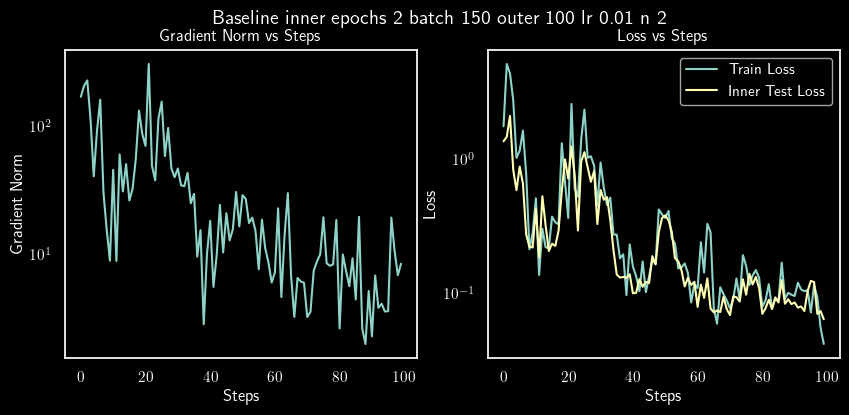

In [11]:
# plot baseline stats

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(stats.grad_norm)
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Gradient Norm")
# make axis y log scale
ax[0].set_yscale("log")
ax[0].set_title("Gradient Norm vs Steps")

ax[1].plot(stats.train_loss, label="Train Loss")
ax[1].plot(stats.inner_test_loss, label="Inner Test Loss")
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].set_title("Loss vs Steps")
ax[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/stats.png")

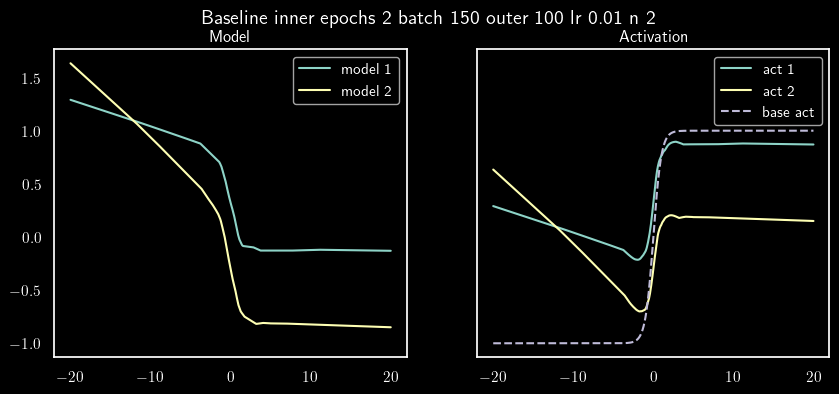

In [12]:
if inner_config.base_act == 'sin':
    base_act = jnp.sin
elif inner_config.base_act == 'tanh':
    base_act = jnp.tanh
elif inner_config.base_act == 'relu':
    base_act = jnp.relu

x = jnp.linspace(-20, 20, 1000).reshape(-1, 1)
model_output_arrays = []
act_arrays = []
for act in acts:
    model_output_arrays.append(jax.vmap(act)(x))
    act_arrays.append(mlp_afunc(x, act, base_act))



fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True, sharex=True)
for i, (model, act) in enumerate(zip(model_output_arrays, act_arrays)):
    axs[0].plot(x, model, label=f"model {i+1}")
    axs[1].plot(x, act, label=f"act {i+1}")

axs[1].plot(x, base_act(x),'--' ,label="base act")

axs[0].set_title("Model")
axs[1].set_title("Activation")
axs[0].legend()
axs[1].legend()

plt.suptitle(f"{' '.join(description.split('_')[:-2])}")
plt.savefig(f"{fig_path}/activations.png")

In [13]:
### Train inner loop for large epochs and multiple runs
runs = 10
config = deepcopy(inner_config)
config.epochs = 5
config.seed = 0

afuncs = [ partial(mlp_afunc, model = outer_model, base_act = base_act) for outer_model in acts]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed+i)
    model = MultiActMLP(config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True)
    _, _ ,inner_results = inner_opt(model =model, 
                                            train_data =train_dataloader,
                                            test_data = test_dataloader,
                                            afuncs = afuncs, 
                                            opt = opt, 
                                            loss_fn=compute_loss_baseline,
                                            config = config, training=True, verbose=False)
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}")
    del model


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 2.3372e-02 test loss: 9.1578e-03
INFO:root:Run 002 train loss: 1.8704e-02 test loss: 1.4128e-02
INFO:root:Run 003 train loss: 1.1659e-02 test loss: 1.3970e-02
INFO:root:Run 004 train loss: 1.8856e-02 test loss: 3.2248e-02
INFO:root:Run 005 train loss: 3.7331e-02 test loss: 1.7695e-02
INFO:root:Run 006 train loss: 3.2155e-02 test loss: 1.9678e-02
INFO:root:Run 007 train loss: 1.5339e-02 test loss: 1.8141e-02
INFO:root:Run 008 train loss: 2.4231e-02 test loss: 1.7720e-02
INFO:root:Run 009 train loss: 3.3265e-02 test loss: 1.6710e-02
INFO:root:Run 010 train loss: 1.4843e-02 test loss: 1.5739e-02


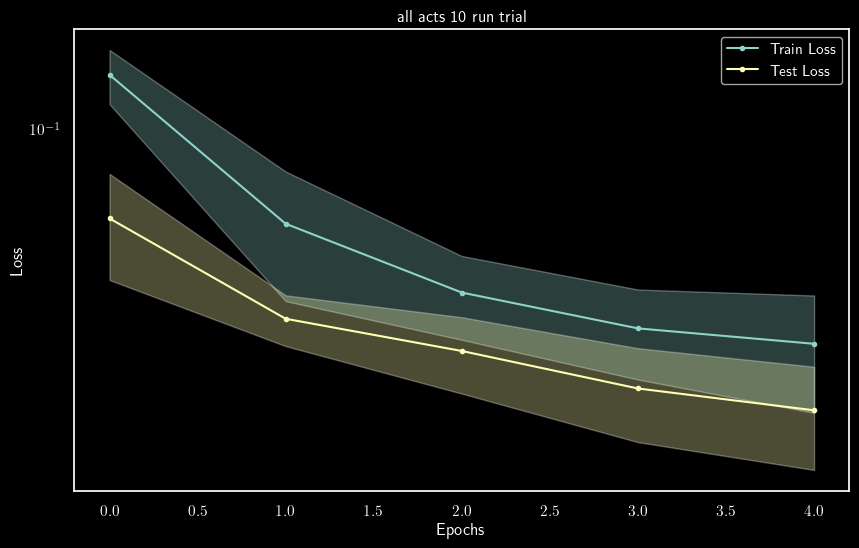

In [14]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

all_acts = [train_losses, test_losses]

train_mean = all_acts[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = all_acts[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = all_acts[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = all_acts[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, '.-',label="Train Loss")
ax.plot(test_mean, '.-',label="Test Loss")
ax.fill_between(np.arange(config.epochs), train_mean-train_std, train_mean+train_std, alpha=0.3)
ax.fill_between(np.arange(config.epochs), test_mean-test_std, test_mean+test_std, alpha=0.3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"all acts {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/all_acts.png")

In [15]:
### Train inner loop for large epochs and multiple runs for act 1
config.seed = 0

afuncs = [ partial(mlp_afunc, model = acts[0], base_act = base_act) ]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed+i)
    model = MultiActMLP(config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True)
    _, _ ,inner_results = inner_opt(model =model, 
                                            train_data =train_dataloader,
                                            test_data = test_dataloader,
                                            afuncs = afuncs, 
                                            opt = opt, 
                                            loss_fn=compute_loss_baseline,
                                            config = config, training=True, verbose=False)
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}")
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 2.5906e-02 test loss: 1.8391e-02
INFO:root:Run 002 train loss: 2.2285e-02 test loss: 1.9918e-02
INFO:root:Run 003 train loss: 5.1739e-02 test loss: 1.6757e-02
INFO:root:Run 004 train loss: 2.0438e-02 test loss: 5.2990e-02
INFO:root:Run 005 train loss: 2.4319e-02 test loss: 2.0070e-02
INFO:root:Run 006 train loss: 2.1221e-02 test loss: 1.6303e-02
INFO:root:Run 007 train loss: 2.1555e-02 test loss: 2.1595e-02
INFO:root:Run 008 train loss: 2.4203e-02 test loss: 2.5703e-02
INFO:root:Run 009 train loss: 3.3818e-02 test loss: 2.1649e-02
INFO:root:Run 010 train loss: 3.2097e-02 test loss: 1.6396e-02


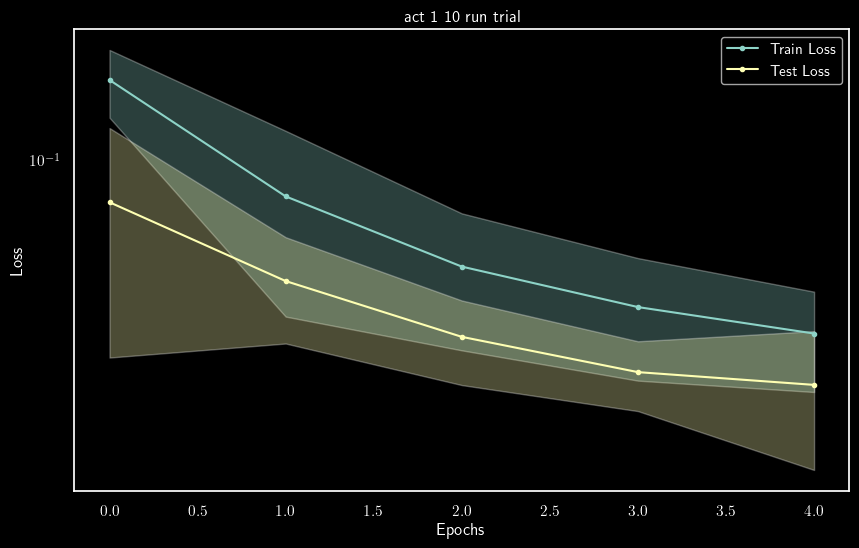

In [16]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_1 = [train_losses, test_losses]

train_mean = act_1[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_1[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_1[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_1[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, '.-',label="Train Loss")
ax.plot(test_mean, '.-',label="Test Loss")
ax.fill_between(np.arange(config.epochs), train_mean-train_std, train_mean+train_std, alpha=0.3)
ax.fill_between(np.arange(config.epochs), test_mean-test_std, test_mean+test_std, alpha=0.3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 1 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_1.png")

In [17]:
### Train inner loop for large epochs and multiple runs for act 2
config.seed = 0

afuncs = [ partial(mlp_afunc, model = acts[1], base_act = base_act) ]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed+i)
    model = MultiActMLP(config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True)
    _, _ ,inner_results = inner_opt(model =model, 
                                            train_data =train_dataloader,
                                            test_data = test_dataloader,
                                            afuncs = afuncs, 
                                            opt = opt, 
                                            loss_fn=compute_loss_baseline,
                                            config = config, training=True, verbose=False)
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}")
    del model


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 1.6758e-02 test loss: 2.3836e-02
INFO:root:Run 002 train loss: 2.6219e-02 test loss: 1.0751e-02
INFO:root:Run 003 train loss: 4.0388e-02 test loss: 1.2552e-02
INFO:root:Run 004 train loss: 1.9636e-02 test loss: 2.1530e-02
INFO:root:Run 005 train loss: 1.4559e-02 test loss: 1.2618e-02
INFO:root:Run 006 train loss: 1.9249e-02 test loss: 1.0860e-02
INFO:root:Run 007 train loss: 2.2235e-02 test loss: 1.4926e-02
INFO:root:Run 008 train loss: 3.1733e-02 test loss: 1.0691e-02
INFO:root:Run 009 train loss: 2.1660e-02 test loss: 1.2549e-02
INFO:root:Run 010 train loss: 2.0890e-02 test loss: 1.3756e-02


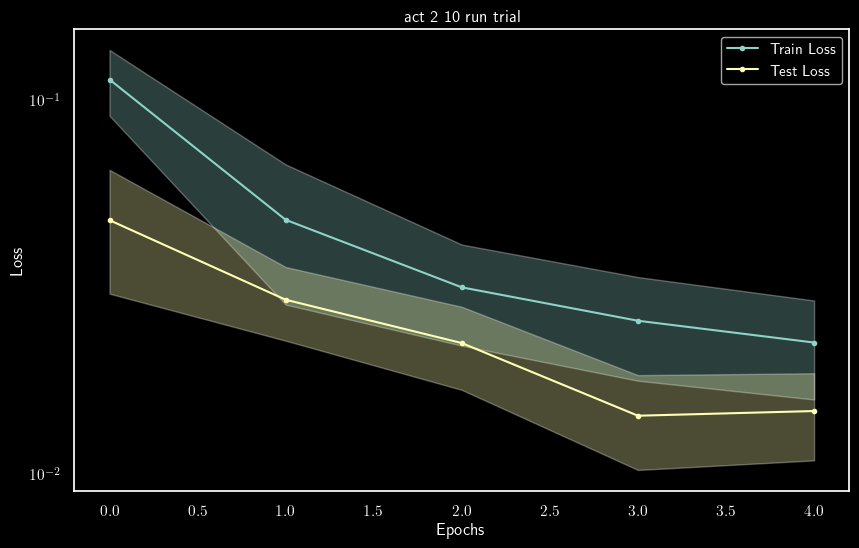

In [18]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_2 = [train_losses, test_losses]

train_mean = act_2[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_2[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_2[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_2[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, '.-',label="Train Loss")
ax.plot(test_mean, '.-',label="Test Loss")
ax.fill_between(np.arange(config.epochs), train_mean-train_std, train_mean+train_std, alpha=0.3)
ax.fill_between(np.arange(config.epochs), test_mean-test_std, test_mean+test_std, alpha=0.3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"act 2 {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_2.png")

In [19]:
### Train inner loop for large epochs and multiple runs for sine
config.seed = 0

afuncs = [ base_act ]
train_losses = []
test_losses = []
for i in trange(runs):
    key = jax.random.PRNGKey(config.seed+i)
    model = MultiActMLP(config.input_dim, config.output_dim, config.hidden_layer_sizes, key, bias=True)
    _, _ ,inner_results = inner_opt(model =model, 
                                            train_data =train_dataloader,
                                            test_data = test_dataloader,
                                            afuncs = afuncs, 
                                            opt = opt, 
                                            loss_fn=compute_loss_baseline,
                                            config = config, training=True, verbose=False)
    train_losses.append(inner_results.train_loss)
    test_losses.append(inner_results.test_loss)
    logging.info(f"Run {i+1 :03d} train loss: {inner_results.train_loss[-1] :.4e} test loss: {inner_results.test_loss[-1] :.4e}")
    del model

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Run 001 train loss: 6.9164e-02 test loss: 7.0387e-02
INFO:root:Run 002 train loss: 4.6904e-02 test loss: 5.6303e-02
INFO:root:Run 003 train loss: 9.3688e-02 test loss: 1.0990e-01
INFO:root:Run 004 train loss: 1.0150e-01 test loss: 9.6521e-02
INFO:root:Run 005 train loss: 7.1545e-02 test loss: 7.8120e-02
INFO:root:Run 006 train loss: 6.6745e-02 test loss: 4.3476e-02
INFO:root:Run 007 train loss: 7.4941e-02 test loss: 7.7776e-02
INFO:root:Run 008 train loss: 4.5718e-02 test loss: 1.6969e-01
INFO:root:Run 009 train loss: 5.1294e-02 test loss: 1.1708e-01
INFO:root:Run 010 train loss: 5.8335e-02 test loss: 1.0211e-01


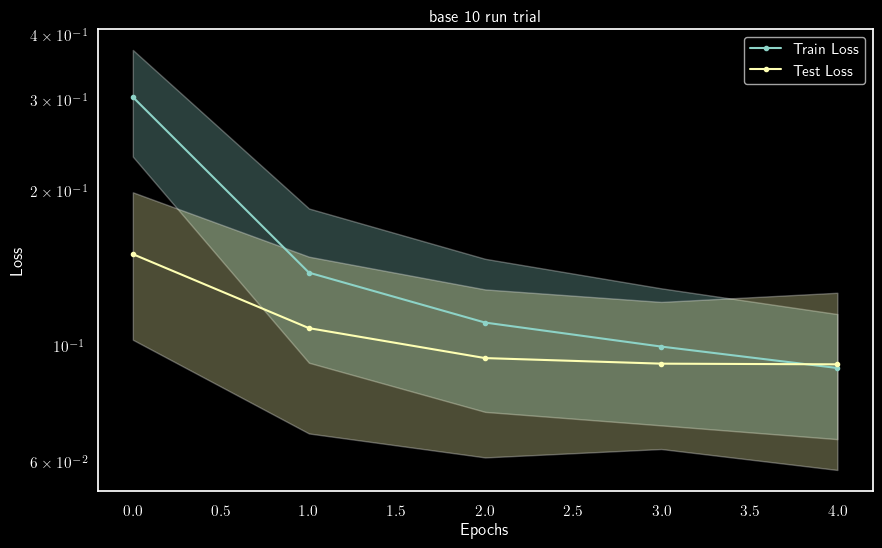

In [20]:
train_losses = jnp.array(train_losses)
test_losses = jnp.array(test_losses)

act_base = [train_losses, test_losses]

train_mean = act_base[0].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_mean = act_base[1].mean(axis=0).reshape(config.epochs, -1).mean(axis=1)
train_std = act_base[0].std(axis=0).reshape(config.epochs, -1).mean(axis=1)
test_std = act_base[1].std(axis=0).reshape(config.epochs, -1).mean(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_mean, '.-',label="Train Loss")
ax.plot(test_mean, '.-',label="Test Loss")
ax.fill_between(np.arange(config.epochs), train_mean-train_std, train_mean+train_std, alpha=0.3)
ax.fill_between(np.arange(config.epochs), test_mean-test_std, test_mean+test_std, alpha=0.3)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.set_title(f"base {runs} run trial")
ax.legend()
plt.savefig(f"{fig_path}/act_base.png")

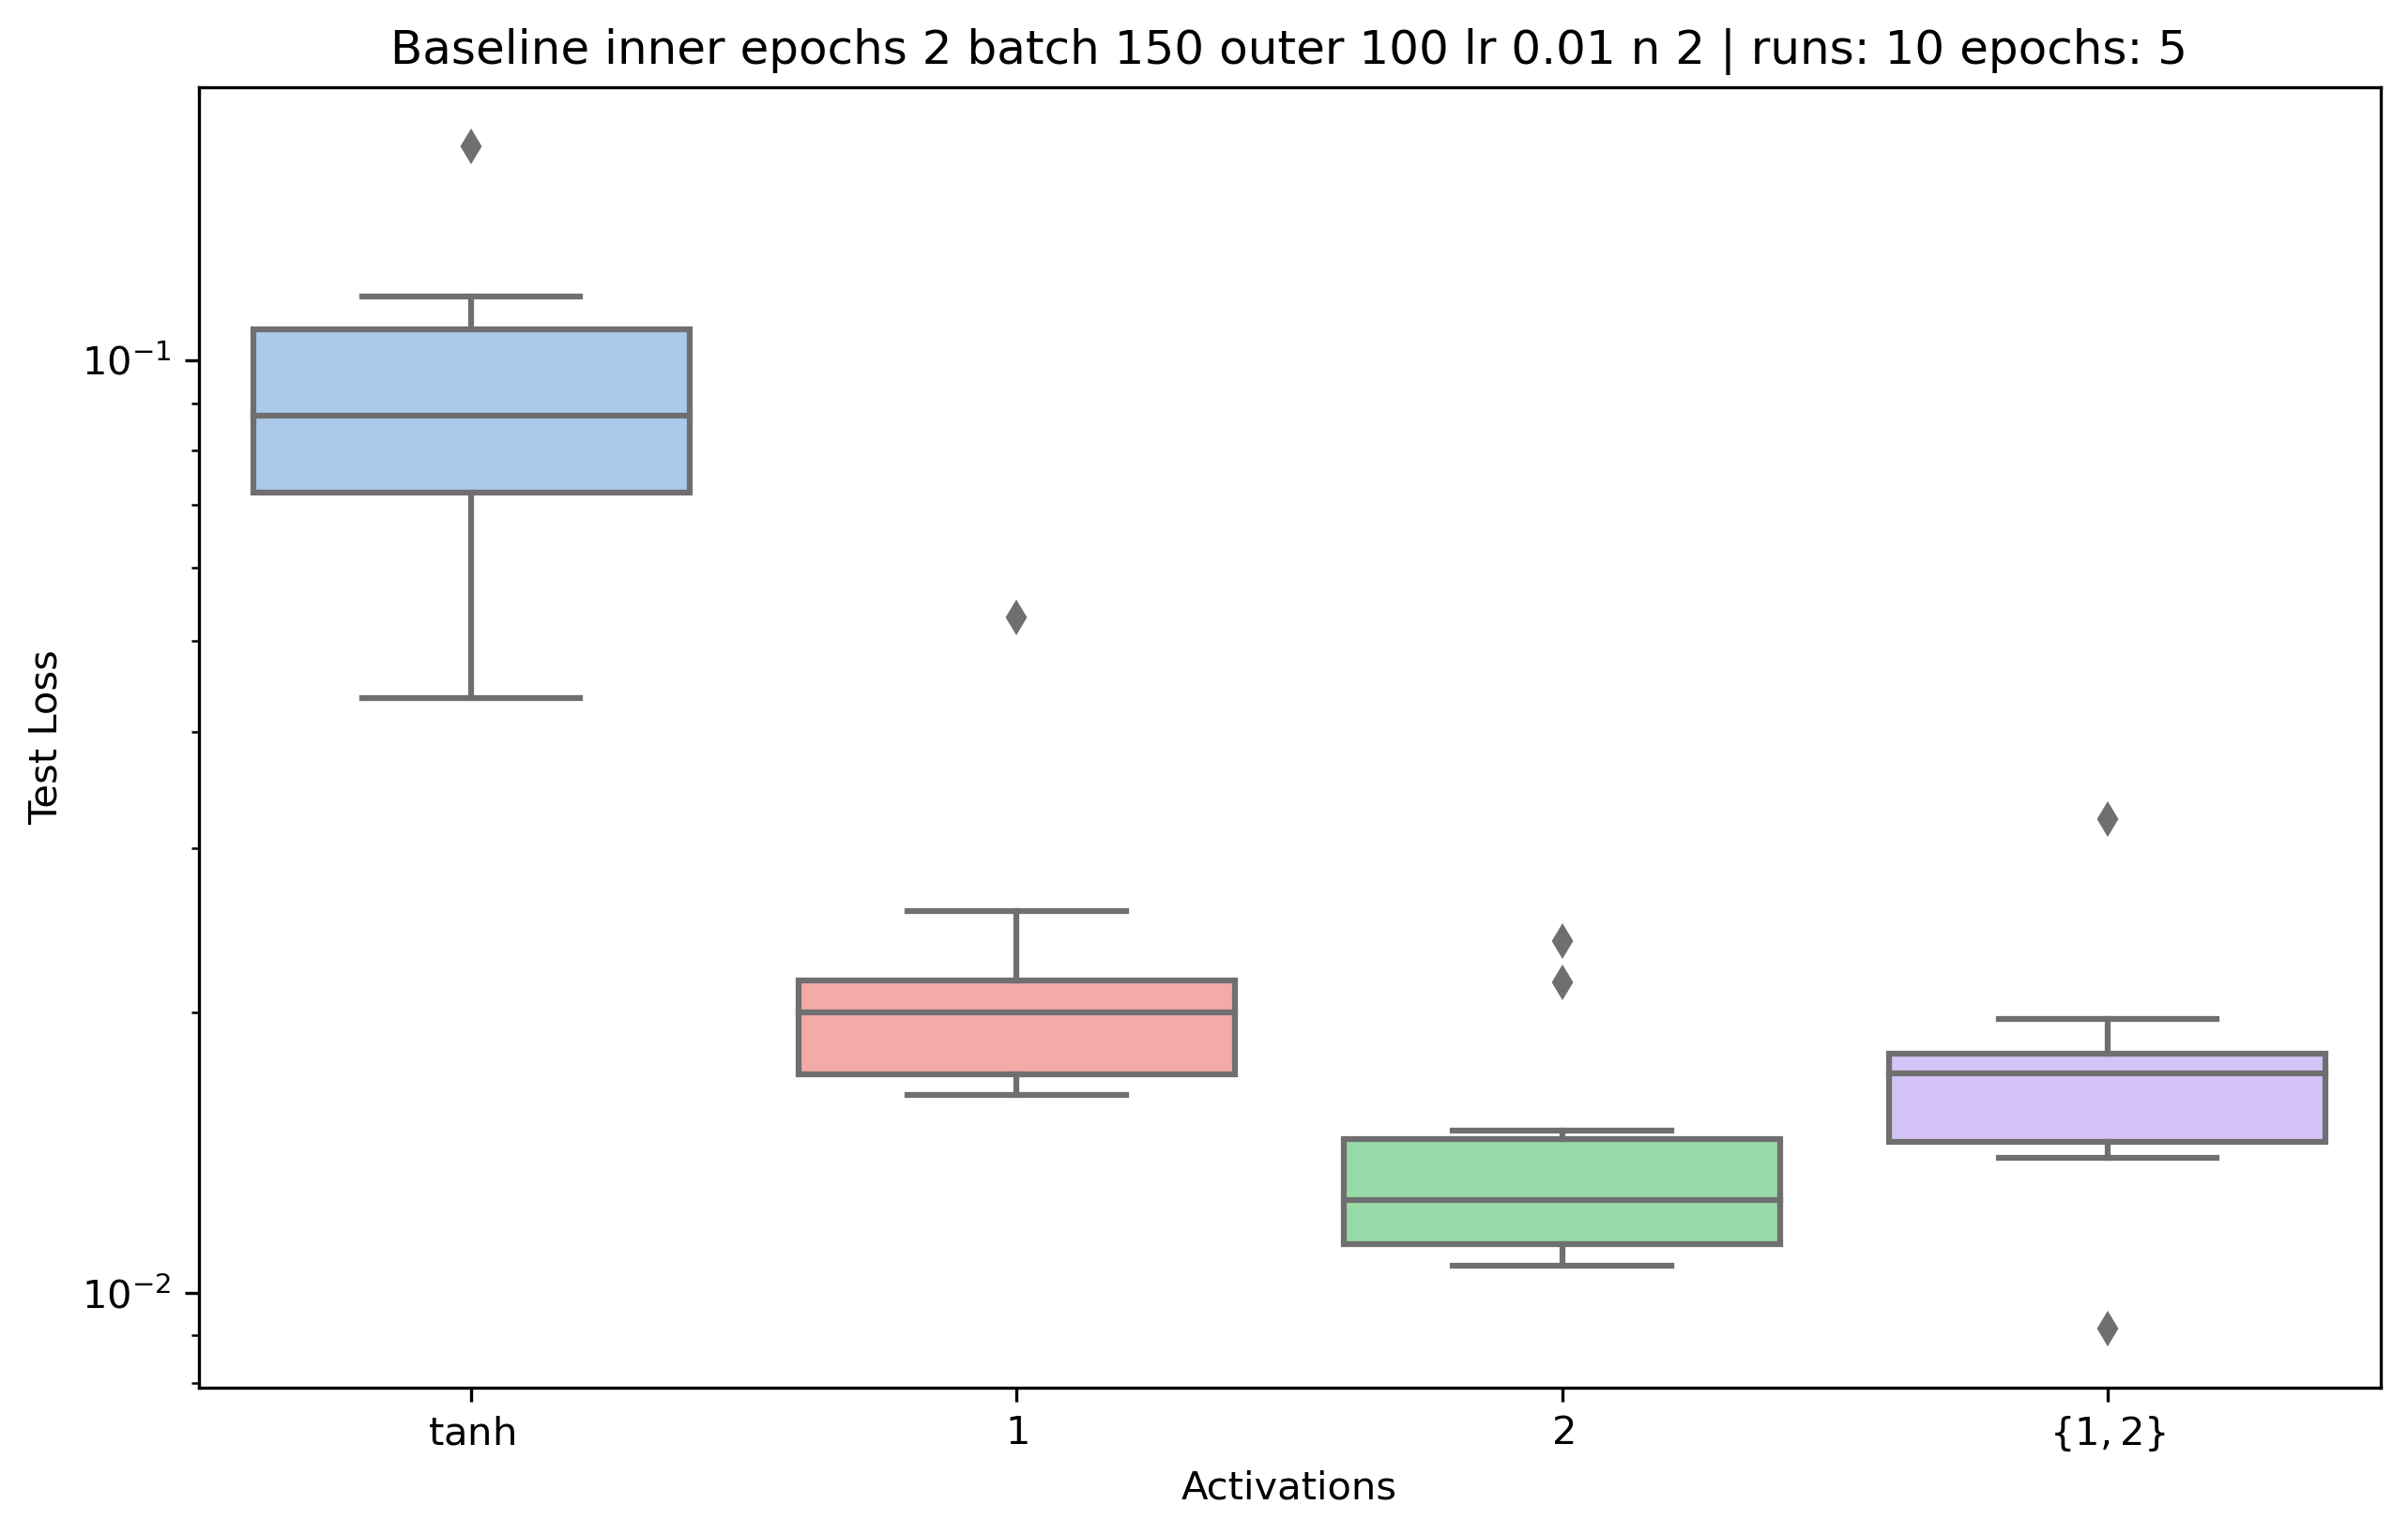

In [21]:
# boxplot using seaborn
plt.style.use('default')
# sns.set_theme(context='paper', style='dark', palette='colorblind', font_scale=1, color_codes=True, rc={'text.usetex' : True})

fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=300)
sns.boxplot(data=[act_base[1][:,-1], act_1[1][:,-1], act_2[1][:,-1], all_acts[1][:,-1] ], ax=ax, palette=['b','r','g','m'])
ax.set_yscale("log")
ax.set_xticklabels([f"$\\{inner_config.base_act}$", "$1$", "$2$", "$\{1,2\}$"])
ax.set_ylabel("Test Loss")
ax.set_xlabel("Activations")
ax.set_title( f"{' '.join(description.split('_')[:-2])} "+ f"| runs: {runs} epochs: {config.epochs}")
plt.savefig(f"{fig_path}/boxplot.png")
plt.savefig(f"{fig_path}/boxplot.pdf")
plt.show()